In [ ]:
!pip install atomicds

In [25]:
%load_ext autoreload
%autoreload 2
%autosave 1

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from atomicds.client import Client
from atomicds.results import RHEEDImageCollection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

work_dir = os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 1 seconds


In [26]:
# To get an API key to run this example, email chris@atomicdatasciences.com
# setup
api_key = "aa3b7d73-ac6a-4b88-8d22-fef6644f3dbd"
api = Client(api_key=api_key, endpoint="https://api.atomicdatasciences.com")

# query
result = api.search("WSe2_0deg", include_organization_data=True)
result = result.sort_values("File Name").reset_index(drop=True)

# fetch
analyzed = api.get(result["Data ID"].to_list())

Obtaining data results: 100%|██████████| 8/8 [00:01<00:00,  6.95it/s]


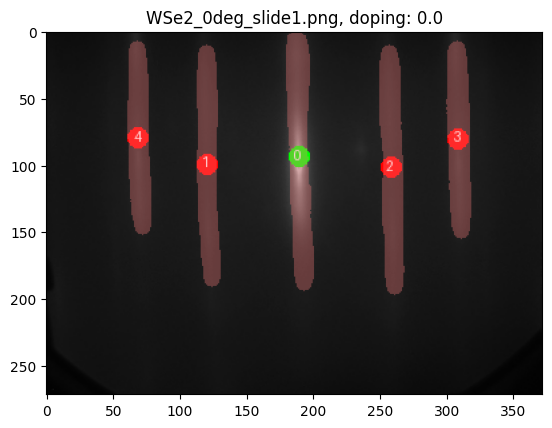

In [20]:
doping_order = [0.06, 0.1, 0.16, 0.24, 0.35, 0., 0., 0.] # 0deg
#doping_order = [0.06, 0.1, 0.16, 0.24, 0.35, 0.]
extra_data = [{
        "doping": value, 
        "name": result["File Name"].iloc[vi]} for vi, value in enumerate(doping_order)]
dataset = RHEEDImageCollection(analyzed, 
    extra_data=extra_data,
    sort_key="doping"
    )
idx = np.random.randint(len(dataset))
plot = dataset[idx].get_plot(symmetrize=False)
plt.imshow(plot)
title = plt.title(f"{dataset.extra_data[idx]['name']}, doping: {dataset.extra_data[idx]['doping']}")

In [21]:
aligned_dataset = dataset.align_fingerprints()
org_feature_df = aligned_dataset.get_pattern_dataframe(symmetrize=True, normalize=True, return_as_features=True)
org_feature_df.dropna(inplace=True, axis=1)

/Users/ccprice/repos/api-client/src/atomicds/results/rheed_image.py:542: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  node_df = pd.concat(node_dfs, axis=0).reset_index(drop=True)


In [ ]:
# experiment design
train_idx = [0, 2, 5, 7]  
test_idx =  [1, 3, 4, 6]
train_correlations = org_feature_df.iloc[train_idx].select_dtypes(include='number').corrwith(org_feature_df.iloc[train_idx]["doping"]).abs().sort_values(ascending=False)
total_correlations = org_feature_df.select_dtypes(include='number').corrwith(org_feature_df["doping"]).abs().sort_values(ascending=False)

X = org_feature_df.select_dtypes(include='number').drop(columns=["doping"])
y = org_feature_df["doping"]

X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

Obtaining data results: 100%|██████████| 8/8 [00:01<00:00,  7.01it/s]


0     WSe2_30deg_V0.06.png
1      WSe2_30deg_V0.1.png
2     WSe2_30deg_V0.16.png
3     WSe2_30deg_V0.24.png
4     WSe2_30deg_V0.35.png
5    WSe2_30deg_slide1.png
6    WSe2_30deg_slide2.png
7    WSe2_30deg_slide3.png
Name: File Name, dtype: object


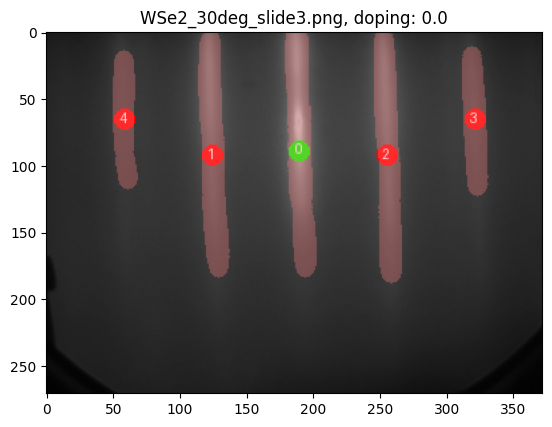

In [23]:
prod_api_key = "d35fc0e5-125b-4fcb-971a-53be49bb8e4b"
api = Client(api_key=prod_api_key) # , endpoint="https://api.atomicdatasciences.com")
result = api.search("WSe2_30deg", include_organization_data=False)
result = result.sort_values("File Name").reset_index(drop=True)
analyzed30 = api.get(result["Data ID"].to_list())

print(result['File Name'])
doping_order = [0.06, 0.1, 0.16, 0.24, 0.35, 0., 0., 0.] # 0deg
#doping_order = [0.06, 0.1, 0.16, 0.24, 0.35, 0.]
dataset30 = RHEEDImageCollection(analyzed30, 
    extra_data=[{
        "doping": value, 
        "name": result["File Name"].iloc[vi]} for vi, value in enumerate(doping_order)],
    sort_key="doping"
    )
idx = np.random.randint(len(dataset30))
plot = dataset30[idx].get_plot(symmetrize=True)
plt.imshow(plot)
plt.title(f"{dataset30.extra_data[idx]['name']}, doping: {dataset30.extra_data[idx]['doping']}")

aligned_dataset30 = dataset30.align_fingerprints()
org_feature_df_30 = aligned_dataset30.get_pattern_dataframe(symmetrize=True, normalize=True, return_as_features=True)
org_feature_df_30.dropna(inplace=True, axis=1)

/var/folders/27/gm005n0s177b05wywv0yp18m0000gn/T/ipykernel_80685/1215089214.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = org_feature_df.select_dtypes(include='number').drop(columns=["doping"])
/var/folders/27/gm005n0s177b05wywv0yp18m0000gn/T/ipykernel_80685/1215089214.py:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X30 = org_feature_df_30.select_dtypes(include='number').drop(columns=["doping"])


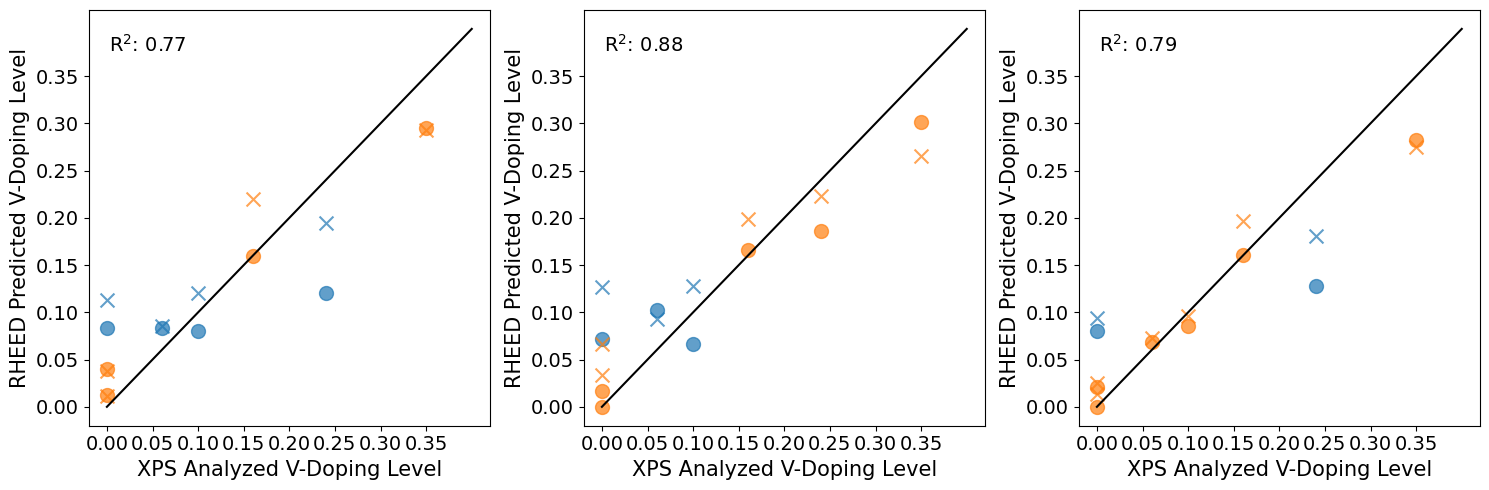

In [24]:
random_0_index = np.random.choice([0,1,2], size=1, replace=False)[0]
others = [ii for ii in range(3) if ii != random_0_index]
train_idx = [5, 7] + others
test_idx =  [random_0_index, 3,4,6]

X = org_feature_df.select_dtypes(include='number').drop(columns=["doping"])

duplicates = X.T.duplicated()
X = X.loc[:, ~duplicates]

y = org_feature_df["doping"]

X30 = org_feature_df_30.select_dtypes(include='number').drop(columns=["doping"])
y30 = org_feature_df_30["doping"]
duplicates = X30.T.duplicated()
X30 = X30.loc[:, ~duplicates]
X30 = X30.drop(columns=[("specular_origin_1", 0)])

exp_design_train_idx = [
    train_idx,
    train_idx + np.random.choice(test_idx, size=1, replace=False).tolist(),
    train_idx + np.random.choice(test_idx, size=2, replace=False).tolist(),
]
fig, ax = plt.subplots(1, len(exp_design_train_idx), figsize=(5*len(exp_design_train_idx), 5))
for ei, exp in enumerate(exp_design_train_idx):
    exp_test_idx = list(set(range(len(org_feature_df))) - set(exp))
    X_train = X.iloc[exp]
    y_train = y.iloc[exp]
    X_test = X.iloc[exp_test_idx]
    y_test = y.iloc[exp_test_idx]

    model0 = BaggingRegressor(estimator=LinearRegression(fit_intercept=True), n_estimators=50)
    model0.fit(X_train, y_train)
    preds = model0.predict(X_test)
    preds = np.clip(preds, 0, 1)
    train_preds = model0.predict(X_train)
    train_preds = np.clip(train_preds, 0, 1)
    total_r2 = model0.score(X, y)
    ax[ei].scatter(y_test, preds, alpha=0.7, s=100, color='#1f77b4')
    ax[ei].scatter(y_train, train_preds, alpha=0.7, s=100, color="#ff7f0e")
    ax[ei].plot([0, 0.4], [0, 0.4], color="k")

    coefficients = np.zeros(X.shape[1])
    for estimator in model0.estimators_:
        coefficients += estimator.coef_

    # Average the coefficients
    coefficients /= model0.n_estimators
    # get the names of the features corresponding to the top 3 coefficients by absolute value
    top3_features = X.columns[np.argsort(np.abs(coefficients))[::-1][:5]]

    X_train = X30.iloc[exp]
    y_train = y30.iloc[exp]
    X_test = X30.iloc[exp_test_idx]
    y_test = y30.iloc[exp_test_idx]

    model30 = BaggingRegressor(estimator=LinearRegression(fit_intercept=True), n_estimators=50)
    model30.fit(X_train, y_train)
    preds = model30.predict(X_test)
    preds = np.clip(preds, 0, 1)
    train_preds = model30.predict(X_train)
    train_preds = np.clip(train_preds, 0, 1)
    total_r2_30 = model30.score(X30, y30)
    ax[ei].scatter(y_test, preds, alpha=0.7, s=100, marker="x", color='#1f77b4')
    ax[ei].scatter(y_train, train_preds, alpha=0.7, s=100, marker="x", color="#ff7f0e")

    # set the x and y ticks to be the same at intervals of 0.05
    ax[ei].set_xticks(np.arange(0, 0.4, 0.05))
    ax[ei].set_yticks(np.arange(0, 0.4, 0.05))

    coefficients = np.zeros(X30.shape[1])
    for estimator in model30.estimators_:
        coefficients += estimator.coef_

    # Average the coefficients
    coefficients /= model30.n_estimators
    # get the names of the features corresponding to the top 3 coefficients by absolute value
    top3_features = X30.columns[np.argsort(np.abs(coefficients))[::-1][:5]]
    # all_predictions = np.array([estimator.predict(X) for estimator in model30.estimators_])
    # all_predictions = np.clip(all_predictions, 0, 1)

    # # Calculate the mean and variance of predictions
    # mean_predictions = np.mean(all_predictions, axis=0)
    # variance_predictions = np.var(all_predictions, axis=0)

    # error_bars = np.sqrt(variance_predictions)

    
    ##### make plot nice
    ax[ei].set_xlabel("XPS Analyzed V-Doping Level", fontsize=15)
    ax[ei].set_ylabel("RHEED Predicted V-Doping Level", fontsize=15)
    # tick and label font increase
    ax[ei].tick_params(axis='both', which='major', labelsize=14)
    # add r2 label
    ax[ei].text(0.05, 0.9, rf"R$^2$: {total_r2:.2f}", fontsize=14, transform=ax[ei].transAxes)
    # ax[ei].errorbar(y, mean_predictions, yerr=error_bars, fmt='.', alpha=0.5)

plt.tight_layout()

In [ ]:
## composition prediction for NIST sample using both angles
prod_api_key = "dcfe8fae-f805-4af3-a119-85246349cf5a"
api = Client(api_key=prod_api_key, endpoint="https://api.atomicdatasciences.com")
result = api.search("NIST", include_organization_data=True)
result = result.sort_values("File Name").reset_index(drop=True)
result = result[(result["File Name"].str.contains("WSe2_after")) | (result["File Name"].str.contains("sapphire"))].reset_index(drop=True)
nist_analyzed = api.get(result["Data ID"].to_list())
# print(result)

combined_extra_data = extra_data + [{
                "name": "nist_sapphire",
                "quality": "none",
                "run_date": pd.to_datetime("2024-04-18"),
                "doping": 1.
                }]

add_nist_data = RHEEDImageCollection(analyzed + [nist_analyzed[0]], extra_data=combined_extra_data, sort_key="doping")

aligned_nist_dataset = add_nist_data.align_fingerprints()
org_nist_feature_df = aligned_nist_dataset.get_pattern_dataframe(symmetrize=True, normalize=True, return_as_features=True)
org_nist_feature_df.dropna(inplace=True, axis=1)

pred = model0.predict(org_nist_feature_df.select_dtypes(include='number').drop(columns=["doping"]))
print(pred)

plt.scatter(y, pred[0:-1])
plt.hlines(pred[-1], 0, y.max(), color="red")
plt.plot([0, 0.4], [0, 0.4], color="red")

add_nist_data30 = RHEEDImageCollection(analyzed30 + [nist_analyzed[1]], extra_data=combined_extra_data, sort_key="doping")

aligned_nist_dataset30 = add_nist_data30.align_fingerprints()
org_nist_feature_df30 = aligned_nist_dataset30.get_pattern_dataframe(symmetrize=True, normalize=True, return_as_features=True)
org_nist_feature_df30.dropna(inplace=True, axis=1)

pred30 = model30.predict(org_nist_feature_df30.select_dtypes(include='number').drop(columns=["doping"]))
print(pred30)

plt.hlines(pred30[-1], 0, y.max(), color="k")